In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from constants import *

# load
train_data = np.load(SAVE_PATH + "face_train_data.npy")
train_label = np.load(SAVE_PATH + "face_train_label.npy")
X_test = np.load(SAVE_PATH + "face_test_data.npy")
y_test = np.load(SAVE_PATH + "face_test_label.npy")

# reshape
train_data = np.reshape(train_data, (-1, 1, IMAGE_SIZE, IMAGE_SIZE))
X_test = np.reshape(X_test, (-1, 1, IMAGE_SIZE, IMAGE_SIZE))

# shuffle and split train and val
X_train, X_val, y_train, y_val = train_test_split(train_data, train_label, test_size=0.1, shuffle=True)

# adjust the size
X_val = np.concatenate([X_train[50000:], X_val], axis=0)
X_train = X_train[:50000]
y_val = np.concatenate([y_train[50000:], y_val], axis=0)
y_train = y_train[:50000]

# info
print("training set: {}".format(X_train.shape))
print("validation set: {}".format(X_val.shape))
print("testing set: {}".format(X_test.shape))

training set: (50000, 1, 64, 64)
validation set: (7246, 1, 64, 64)
testing set: (3700, 1, 64, 64)


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
from torch.autograd import Variable
from sklearn.metrics import accuracy_score

class EmoNet(nn.Module):
    def __init__(self):
        super(EmoNet, self).__init__()
        self.extractor = nn.Sequential(nn.Conv2d(1, 32, 3, padding=1),
                                       nn.ReLU(),
                                       nn.MaxPool2d(2, 2),
                                       nn.BatchNorm2d(32),
                                       nn.Dropout(0.3),
                                       nn.Conv2d(32, 64, 3, padding=1),
                                       nn.ReLU(),
                                       nn.MaxPool2d(2, 2),
                                       nn.BatchNorm2d(64),
                                       nn.Dropout(0.3),
                                       nn.Conv2d(64, 64, 3, padding=1),
                                       nn.ReLU(),
                                       nn.MaxPool2d(2, 2),
                                       nn.BatchNorm2d(64),
                                       nn.Dropout(0.3),
                                       nn.Conv2d(64, 128, 3, padding=1),
                                       nn.ReLU(),
                                       nn.MaxPool2d(2, 2),
                                       nn.BatchNorm2d(128))
        self.classifier = nn.Sequential(nn.Linear(128 * 4 * 4, 128),
                                        nn.ReLU(),
                                        nn.Dropout(),
                                        nn.Linear(128, 6),
                                        nn.Sigmoid())
        self.train_acc = []
        self.val_acc = []
    
    def forward(self, inputs):
        inputs = Variable(torch.from_numpy(inputs)).float().cuda()
        feature = self.extractor(inputs)
        flattened = feature.view(-1, feature.size(1) * feature.size(2) * feature.size(3))
        outputs = self.classifier(flattened)
        
        return outputs
    
    def predict(self, inputs):
        pred = self.forward(inputs)
        _, pred = torch.max(pred, dim=1)
        pred = pred.cpu().data.numpy()
        
        return pred
    
    def eval(self, inputs, labels):
        pred = self.predict(inputs)
        
        return accuracy_score(pred, labels)
    
    def test(self, inputs, labels, batch):
        num_iter = inputs.shape[0] // batch
        inputs_list = np.array_split(inputs, num_iter)
        labels_list = np.array_split(labels, num_iter)
        scores = []
        for i in range(num_iter):
            scores.append(self.eval(inputs_list[i], labels_list[i]))
            
        return np.mean(scores)
    
    def fit(self, X_train, y_train, X_val, y_val, lr, batch, epoch):
        num_iter_train = X_train.shape[0] // batch
        num_iter_val = X_val.shape[0] // batch
        X_train_list = np.array_split(X_train, num_iter_train, axis=0)
        y_train_list = np.array_split(y_train, num_iter_train, axis=0)
        X_val_list = np.array_split(X_val, num_iter_val, axis=0)
        y_val_list = np.array_split(y_val, num_iter_val, axis=0)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.parameters(), lr=lr)
        # reduce the lr in validation acc plateau
        scheduler = ReduceLROnPlateau(optimizer, patience=5)
        for epoch_id in range(epoch):
            running_train_acc = []
            running_val_acc = []
            running_train_loss = 0.0
            running_val_loss = 0.0
            # train
            for iter_id in range(num_iter_train):
                optimizer.zero_grad()
                outputs = self.forward(X_train_list[iter_id])
                running_train_acc.append(self.eval(X_train_list[iter_id], y_train_list[iter_id]))
                train_loss = criterion(outputs, Variable(torch.from_numpy(y_train_list[iter_id])).long().cuda())
                train_loss.backward()
                optimizer.step()
                running_train_loss += train_loss.data[0]
            self.train_acc.append(np.mean(running_train_acc))
            # val
            for iter_id in range(num_iter_val):
                running_val_acc.append(self.eval(X_val_list[iter_id], y_val_list[iter_id]))
                running_val_loss += criterion(self.forward(X_val_list[iter_id]), Variable(torch.from_numpy(y_val_list[iter_id])).long().cuda()).data[0]
            self.val_acc.append(np.mean(running_val_acc))
            # lr decay
            scheduler.step(running_val_loss / num_iter_val)
            # info per epoch
            print("epoch: {}, train_loss: {}, train_acc: {}, val_loss: {}, val_acc: {}".format(
                    epoch_id + 1,
                    round(running_train_loss / num_iter_train, 5),
                    round(self.train_acc[-1], 5),
                    round(running_val_loss / num_iter_val, 5),
                    round(self.val_acc[-1], 5)
                ))
        print("complete...\n")
        
    def draw_curve(self):        
        plt.plot(range(len(self.train_acc)), self.train_acc, 'b-', label='train_acc')
        plt.plot(range(len(self.val_acc)), self.val_acc, 'r-', label='val_acc')
        plt.legend()
        plt.show()

In [3]:
model = EmoNet().cuda()
print(model)

EmoNet(
  (extractor): Sequential(
    (0): Conv2d (1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
    (4): Dropout(p=0.3)
    (5): Conv2d (32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (9): Dropout(p=0.3)
    (10): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (14): Dropout(p=0.3)
    (15): Conv2d (64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16): ReLU()
    (17): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (18): BatchNorm2d(128, eps=1e-05, moment

In [4]:
model.fit(X_train, y_train, X_val, y_val, 2e-3, 500, 100)

epoch: 1, train_loss: 1.61554, train_acc: 0.3818, val_loss: 1.53547, val_acc: 0.46438
epoch: 2, train_loss: 1.50531, train_acc: 0.48512, val_loss: 1.48743, val_acc: 0.50138
epoch: 3, train_loss: 1.46836, train_acc: 0.52064, val_loss: 1.46032, val_acc: 0.52415
epoch: 4, train_loss: 1.44602, train_acc: 0.54308, val_loss: 1.45099, val_acc: 0.54016
epoch: 5, train_loss: 1.42818, train_acc: 0.55898, val_loss: 1.43926, val_acc: 0.55106
epoch: 6, train_loss: 1.41528, train_acc: 0.56902, val_loss: 1.43799, val_acc: 0.55934
epoch: 7, train_loss: 1.40706, train_acc: 0.58058, val_loss: 1.42461, val_acc: 0.56444
epoch: 8, train_loss: 1.39721, train_acc: 0.5875, val_loss: 1.4256, val_acc: 0.57149
epoch: 9, train_loss: 1.38874, train_acc: 0.59616, val_loss: 1.42324, val_acc: 0.56927
epoch: 10, train_loss: 1.38272, train_acc: 0.60496, val_loss: 1.41783, val_acc: 0.57065
epoch: 11, train_loss: 1.37914, train_acc: 0.60778, val_loss: 1.41156, val_acc: 0.5799
epoch: 12, train_loss: 1.37277, train_acc: 0.

epoch: 95, train_loss: 1.28021, train_acc: 0.71084, val_loss: 1.39724, val_acc: 0.60668
epoch: 96, train_loss: 1.28202, train_acc: 0.71252, val_loss: 1.39004, val_acc: 0.60323
epoch: 97, train_loss: 1.28036, train_acc: 0.7102, val_loss: 1.3909, val_acc: 0.60323
epoch: 98, train_loss: 1.28, train_acc: 0.71244, val_loss: 1.39331, val_acc: 0.60654
epoch: 99, train_loss: 1.28092, train_acc: 0.70988, val_loss: 1.38866, val_acc: 0.6104
epoch: 100, train_loss: 1.28114, train_acc: 0.71162, val_loss: 1.39258, val_acc: 0.60489
complete...



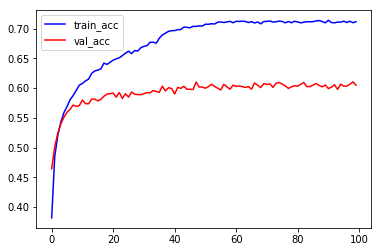

In [5]:
model.draw_curve()

In [6]:
model.test(X_test, y_test, 100)

0.60594594594594609